# Data Loading and Cleaning

Loads and examines the initial structure of the datasets required.

In [553]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [554]:
# Load Data
df_adjusted = pd.read_csv('../data/combined_data_season_adjusted.csv')
df_not_adjusted = pd.read_csv('../data/combined_data_season_not_adjusted.csv')
categories = pd.read_csv('../data/code_categories.csv')

- **`df_adjusted` (*combined_data_season_adjusted*)**: Contains the main dataset with seasonally adjusted sales data for retail and food services from 2017–2023.
- 
**`df_not_adjusted` (*combined_data_season_not_adjusted*)**: Contains the main dataset with raw sales data for retail and food services from 2017–2023.
  
- **`categories` (*code_categories*)**: Provides a mapping of category codes to descriptive names, enabling a better understanding of each retail and food service segment.


In [555]:
df_adjusted.head()

,cell_value,time_slot_id,error_data,category_code,seasonally_adj,data_type_code,time,us
0,688810.00,0,no,44X72,yes,SM,2023-06,1
1,703256.00,0,no,44X72,yes,SM,2023-12,1
2,11124.00,0,no,4521E,yes,SM,2023-04,1
3,10871.00,0,no,4521E,yes,SM,2023-10,1
4,415563.00,0,no,44000,yes,SM,2017-02,1


In [556]:
categories.head()

,category_code,category_name,high_level_category
0,44X72,Retail Trade and Food Services,Retail and Food Services
1,4521E,Department Stores,Retail Trade
2,44000,Retail Trade,Retail Trade
3,444,Building Material and Garden Equipment and Sup...,Retail Trade
4,44Y72,"Retail Trade and Food Services, ex Auto",Retail and Food Services


In [557]:
df_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cell_value      3500 non-null   float64
 1   time_slot_id    3500 non-null   int64  
 2   error_data      3500 non-null   object 
 3   category_code   3500 non-null   object 
 4   seasonally_adj  3500 non-null   object 
 5   data_type_code  3500 non-null   object 
 6   time            3500 non-null   object 
 7   us              3500 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 218.9+ KB


In [558]:
pd.options.display.float_format = '{:.2f}'.format

As the dataset contains no `null` values, we proceed to examine the unique values in each column to understand the variability and structure of the data.

In [559]:
for column in df_adjusted.columns:
    print(f"Column: {column}")
    print(f"Unique values: {df_adjusted[column].unique()}")
    print(f"Number of unique values: {df_adjusted[column].nunique()}\n")

Column: cell_value
Unique values: [6.88810e+05 7.03256e+05 1.11240e+04 ... 7.60000e+00 4.80000e+00
 5.00000e+00]
Number of unique values: 1797

Column: time_slot_id
Unique values: [0]
Number of unique values: 1

Column: error_data
Unique values: ['no' 'yes']
Number of unique values: 2

Column: category_code
Unique values: ['44X72' '4521E' '44000' '444' '44Y72' '451' '453' '4451' '441' '454'
 '441X' '443' '447' '446' '452' '448' '445' '44W72' '442' '44Z72' '722']
Number of unique values: 21

Column: seasonally_adj
Unique values: ['yes']
Number of unique values: 1

Column: data_type_code
Unique values: ['SM' 'E_SM']
Number of unique values: 2

Column: time
Unique values: ['2023-06' '2023-12' '2023-04' '2023-10' '2017-02' '2017-08' '2017-10'
 '2017-01' '2017-07' '2018-09' '2019-05' '2019-11' '2020-03' '2020-09'
 '2021-02' '2021-08' '2019-02' '2019-08' '2020-06' '2020-12' '2017-06'
 '2017-12' '2017-05' '2018-01' '2018-07' '2020-11' '2020-01' '2020-07'
 '2021-03' '2021-09' '2021-01' '2021-0

Convert data types to appropriate types

 -`time` to `Datetime` format for easier analysis.

In [560]:
df_adjusted['time'] = pd.to_datetime(df_adjusted['time'], format='%Y-%m')
df_not_adjusted['time'] = pd.to_datetime(df_not_adjusted['time'], format='%Y-%m')
df_adjusted = df_adjusted.sort_values(by='time', ascending=True)
df_not_adjusted = df_not_adjusted.sort_values(by='time', ascending=True)

Rename column names for better interpretation.

In [561]:
df_adjusted = df_adjusted.rename(columns={'seasonally_adj': 'seasonally_adjusted'})
df_not_adjusted = df_not_adjusted.rename(columns={'seasonally_adj': 'seasonally_adjusted'})
df_adjusted['seasonally_adjusted'] = df_adjusted['seasonally_adjusted'].map({'yes': True, 'no': False})
df_not_adjusted['seasonally_adjusted'] = df_not_adjusted['seasonally_adjusted'].map({'yes': True, 'no': False})

Proceed to drop unnecessary columns.

In [562]:
df_adjusted = df_adjusted.drop(columns=['time_slot_id', 'us'])
df_not_adjusted = df_not_adjusted.drop(columns=['time_slot_id', 'us'])

Merge the main dataset with a mapping dataset (categories) using the `category_code` column. 

This step assigns descriptive names to each `category_code`, making the dataset more interpretable.

In [563]:
df_adjusted = df_adjusted.merge(categories, on='category_code', how='left')
df_not_adjusted = df_not_adjusted.merge(categories, on='category_code', how='left')

Inspect `error_data` and `cell_value` for the two unique `data_type_code`s.

In [564]:
# Group by 'data_type_code' and get unique values of 'error_data' and basic stats for 'cell_value'
result = data.groupby('data_type_code').agg({
    'error_data': 'unique',     
    'cell_value': ['unique', 'count', 'min', 'max'] 
})

result

error_data                                         cell_value  \
                   unique                                             unique   
data_type_code                                                                 
E_SM                [yes]  [0.9, 0.7, 0.0, 0.6, 1.9, 2.3, 0.5, 1.2, 2.5, ...   
SM                   [no]  [688810.0, 703256.0, 11124.0, 10871.0, 415563....   

                                        
               count     min       max  
data_type_code                          
E_SM            1736    0.00      7.60  
SM              1764 2885.00 703256.00

`SM (Sales Monthly)`: Represents raw sales figures.

`E_SM (Standard Error of Monthly Sales Percent Change)`: Reflects the standard error for monthly sales.

Due to their differing scales and contexts, separating these datasets ensures more accurate and focused analysis.

In [565]:
df_adjusted = df_adjusted.drop(columns=['error_data'])
df_not_adjusted = df_not_adjusted.drop(columns=['error_data'])

In [566]:
sm_df_adjusted = df_adjusted[df_adjusted['data_type_code'] == 'SM']
esm_df_adjusted = df_adjusted[df_adjusted['data_type_code'] == 'E_SM']
sm_df_not_adjusted = df_not_adjusted[df_not_adjusted['data_type_code'] == 'SM']
esm_df_not_adjusted = df_not_adjusted[df_not_adjusted['data_type_code'] == 'E_SM']

Rename the `cell_value` column to reflect its respective data type for clarity.

Drop unnecessary columns.

In [567]:
sm_df_adjusted = sm_df_adjusted.drop(columns=['seasonally_adjusted','data_type_code'])
esm_df_adjusted = esm_df_adjusted.drop(columns=['seasonally_adjusted','data_type_code'])
sm_df_not_adjusted = sm_df_not_adjusted.drop(columns=['seasonally_adjusted','data_type_code'])
esm_df_notadjusted = esm_df_not_adjusted.drop(columns=['seasonally_adjusted','data_type_code'])

In [568]:
sm_df_adjusted = sm_df_adjusted.rename(columns={'cell_value': 'monthly_sales'})
esm_df_adjusted = esm_df_adjusted.rename(columns={'cell_value': 'standard_error_of_monthly_percent_change'})
sm_df_not_adjusted = sm_df_not_adjusted.rename(columns={'cell_value': 'monthly_sales'})
esm_df_not_adjusted = esm_df_not_adjusted.rename(columns={'cell_value': 'standard_error_of_monthly_percent_change'})

In [569]:
sm_df_not_adjusted['monthly_sales'].apply(float.is_integer).all()

np.True_

`monthy_sales` seem to be all rounded upto the whole number.

In [570]:
sm_df_not_adjusted['monthly_sales'] = sm_df_not_adjusted['monthly_sales'].astype(int)
sm_df_adjusted['monthly_sales'] = sm_df_adjusted['monthly_sales'].astype(int)

In [571]:
sm_df_not_adjusted.head()

,monthly_sales,category_code,time,category_name,high_level_category
1,6220,451,2017-01-01,"Sporting Goods, Hobby, Musical Instrument, and...",Retail Trade
5,78223,441X,2017-01-01,Auto and Other Motor Vehicles,Retail Trade
7,8408,442,2017-01-01,Furniture and Home Furnishings Stores,Retail Trade
8,52570,4451,2017-01-01,Grocery Stores,Retail Trade
10,25643,446,2017-01-01,Health and Personal Care Stores,Retail Trade


In [572]:
output_directory = "../data/"

# Export DataFrames to CSV files
sm_df_adjusted.to_csv(f"{output_directory}sm_df_adjusted.csv", index=False)
esm_df_adjusted.to_csv(f"{output_directory}esm_df_adjusted.csv", index=False)
sm_df_not_adjusted.to_csv(f"{output_directory}sm_df_not_adjusted.csv", index=False)
esm_df_not_adjusted.to_csv(f"{output_directory}esm_df_not_adjusted.csv", index=False)

# Visualizations

In [573]:
sales_trends = sm_df_adjusted.copy()
sales_trends['year'] = sm_df_adjusted['time'].dt.year
yearly_sales_avg = sales_trends.groupby(['year', 'category_name'])['monthly_sales'].mean().reset_index()
yearly_sales_sum = sales_trends.groupby(['year', 'category_name'])['monthly_sales'].sum().reset_index()
sales_avg = sales_trends.groupby(['category_name'])['monthly_sales'].mean().reset_index()
sales_sum = sales_trends.groupby(['category_name'])['monthly_sales'].sum().reset_index()

In [574]:
sales_avg = sales_avg.sort_values(by=['monthly_sales'], ascending=False)
sales_avg

,category_name,monthly_sales
16,Retail Trade and Food Services,569020.50
19,"Retail Trade and Food Services, ex Gas",522556.42
15,Retail Trade,500321.48
17,"Retail Trade and Food Services, ex Auto",456869.10
18,"Retail Trade and Food Services, ex Auto and Gas",410405.01
13,Motor Vehicle and Parts Dealers,112151.40
0,Auto and Other Motor Vehicles,103182.94
14,Nonstore Retailers,80068.57
6,Food and Beverage Stores,70586.60
5,Food Services and Drinking Places,68699.02


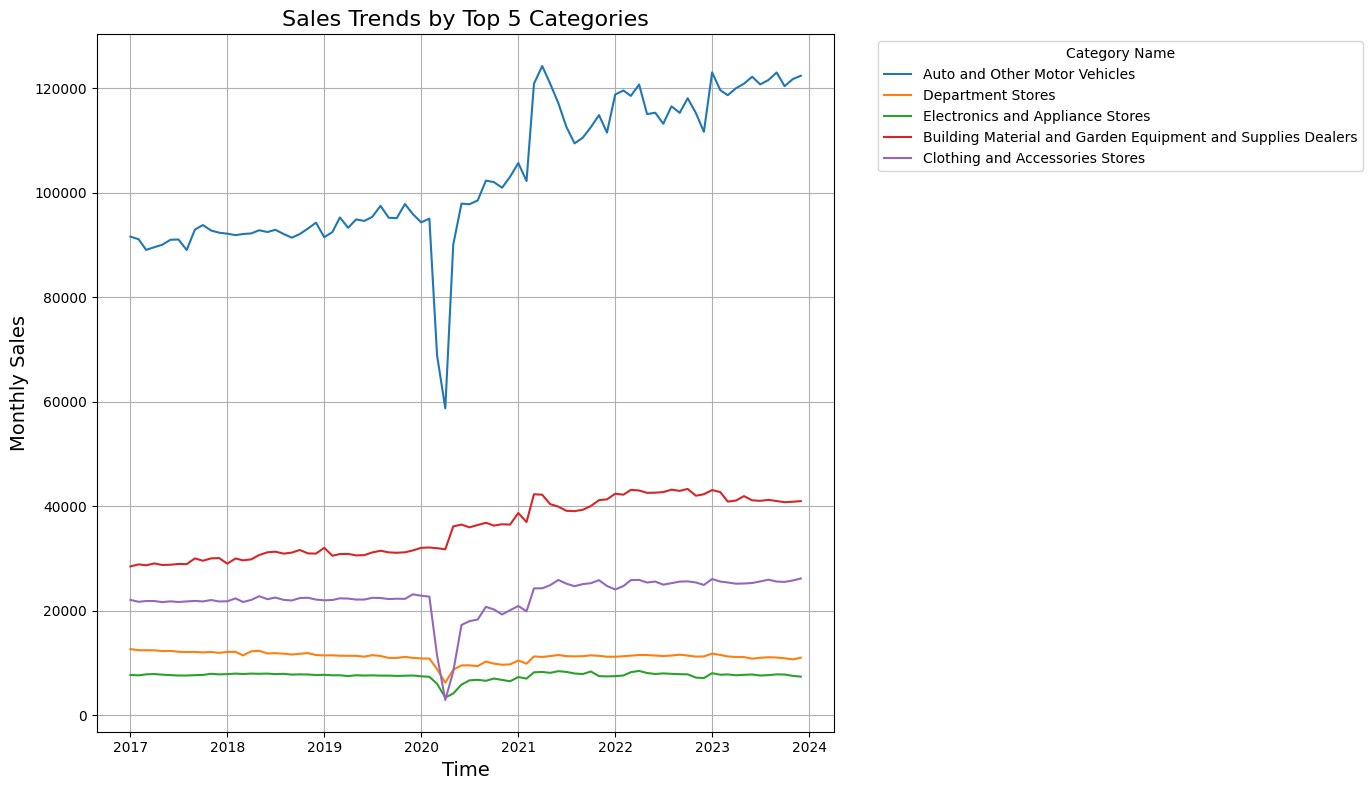

In [580]:
top_categories = sales_avg['category_name'].head(5)
sales_trends_top = sales_trends[sales_trends['category_name'].isin(top_categories)]

plt.figure(figsize=(14, 8))

for category in sales_trends_top['category_name'].unique():
    category_data = sales_trends_top[sales_trends_top['category_name'] == category]
    plt.plot(category_data['time'], category_data['monthly_sales'], label=category)

# Add titles and labels
plt.title('Sales Trends by Top 5 Categories', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.legend(title='Category Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(visible=True)
plt.tight_layout()

plt.show()


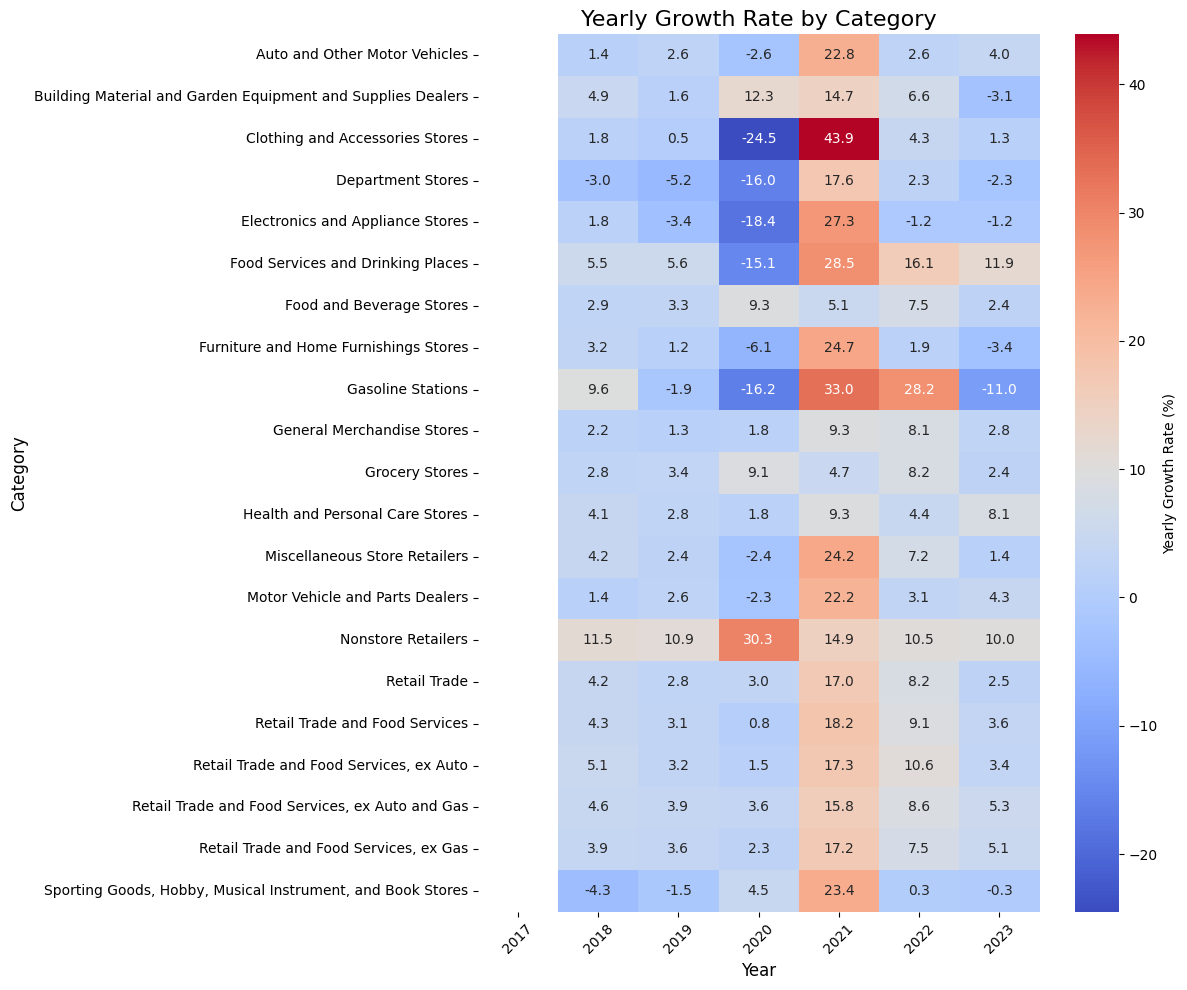

In [577]:
sales_trends['year'] = sales_trends['time'].dt.year
yearly_sales = sales_trends.groupby(['year', 'category_name'])['monthly_sales'].sum().reset_index()

yearly_sales['yearly_growth_rate'] = yearly_sales.groupby('category_name')['monthly_sales'].pct_change() * 100

heatmap_data = yearly_sales.pivot(index='category_name', columns='year', values='yearly_growth_rate')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': 'Yearly Growth Rate (%)'})
plt.title("Yearly Growth Rate by Category", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Create a table listing categories by total sales (descending order) for each year
ranked_sales = yearly_sales.sort_values(by=['year', 'monthly_sales'], ascending=[True, False])

In [578]:
ranked_sales.head(5)

,year,category_name,monthly_sales,yearly_growth_rate
16,2017,Retail Trade and Food Services,5736879,NaN
19,2017,"Retail Trade and Food Services, ex Gas",5259277,NaN
15,2017,Retail Trade,5043678,NaN
17,2017,"Retail Trade and Food Services, ex Auto",4548921,NaN
18,2017,"Retail Trade and Food Services, ex Auto and Gas",4071319,NaN
